
# Predicting Accidents in New York City
## Capstone Project 1
### Gene Hopping
### Springboard Data Science Career Track
## Part 1: Accident Data Wrangling
# Contents <a id='Contents'/>

[Data wrangling](#data_wrangling)

[EDA](#EDA)


[Back to Contents](#Contents)

Data source: https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions-Crashes/h9gi-nx95

## Data Wrangling<a id='data_wrangling'/>

In [33]:
#import libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

Read data into a dataframe from the csv file

In [34]:
#low_memory=False because error recieved: Columns (3) have mixed types
traffic_df = pd.read_csv('NYPD_Motor_Vehicle_Collisions.csv', low_memory=False)

In [35]:
traffic_df[:29].head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,04/16/2019,0:00,MANHATTAN,10010,40.737885,-73.98091,"(40.737885, -73.98091)",2 AVENUE,EAST 23 STREET,NaN,...,Traffic Control Disregarded,NaN,NaN,NaN,4116367,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
1,04/16/2019,0:00,QUEENS,11354,40.762756,-73.82261,"(40.762756, -73.82261)",PARSONS BOULEVARD,38 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4115878,Sedan,Box Truck,NaN,NaN,NaN
2,04/16/2019,0:00,QUEENS,11367,40.729404,-73.82282,"(40.729404, -73.82282)",NaN,NaN,144-04 70 AVENUE,...,Unspecified,NaN,NaN,NaN,4115808,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
3,04/16/2019,0:00,QUEENS,11413,40.665485,-73.75374,"(40.665485, -73.75374)",SOUTH CONDUIT AVENUE,224 STREET,NaN,...,Unspecified,NaN,NaN,NaN,4115916,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
4,04/16/2019,0:00,NaN,NaN,40.810173,-73.95117,"(40.810173, -73.95117)",WEST 125 STREET,NaN,NaN,...,Driver Inattention/Distraction,NaN,NaN,NaN,4116309,Station Wagon/Sport Utility Vehicle,Taxi,NaN,NaN,NaN


Thoughts on a quick inspection of above:
-Will want to merge the DATE AND TIME columns and put into DateTime format and make the index 
-Looks like the LOCATION column contains the same information as LAT AND LONG - take a deeper look.
-Unsure if UNIQUE KEY is important - look into this, drop if just duplicated data
Let's see what the missing columns in middle are, and what level of missing 

The questions we’re asking relate broadly to all accidents across all New York, therefore the specific locations of accidents, or vehicle counts is not needed. We’re going to aggregate the accidents (and counts), to give counts per hour. Each entry in the accidents dataset pertains to an accident, therefore we can sort by date and time and aggregate them to get the count.

## Exploratory Data Analysis

In [36]:
#take a look at column titles
traffic_df.columns

Index(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5'],
      dtype='object')

So angry! Change to lower case and get rid of those spaces

In [37]:
#convert upper case to lower case
traffic_df.columns = map(str.lower, traffic_df.columns)

In [38]:
#replace blank spaces with underscore
traffic_df.columns = traffic_df.columns.str.replace(" ", "_") #can I use this format above?

In [39]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480084 entries, 0 to 1480083
Data columns (total 29 columns):
date                             1480084 non-null object
time                             1480084 non-null object
borough                          1037441 non-null object
zip_code                         1037266 non-null object
latitude                         1294208 non-null float64
longitude                        1294208 non-null float64
location                         1294208 non-null object
on_street_name                   1196093 non-null object
cross_street_name                1007087 non-null object
off_street_name                  191840 non-null object
number_of_persons_injured        1480067 non-null float64
number_of_persons_killed         1480053 non-null float64
number_of_pedestrians_injured    1480084 non-null int64
number_of_pedestrians_killed     1480084 non-null int64
number_of_cyclist_injured        1480084 non-null int64
number_of_cyclist_killed        

There are 1.48 million rows in this dataset. However, only 1.29 million rows have latitude and longitude values. For any geospatial analyses, position is critical, so drop all rows that do not indicate location of accident.

In [40]:
#convert date and time to datetime object in case it's more convenient later
traffic_df['datetime'] = pd.to_datetime(traffic_df['date'] + ' ' + traffic_df['time'])
#set date  type to datetime64
traffic_df.date = traffic_df.date.astype("datetime64")
# Probably neet to convert time to something - may be able to use datetime instead.
traffic_df = traffic_df.set_index(pd.DatetimeIndex(traffic_df['datetime']))

In [41]:
#Take a look
traffic_df.head(5)

,date,time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,unique_key,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2019-04-16,2019-04-16,0:00,MANHATTAN,10010,40.737885,-73.98091,"(40.737885, -73.98091)",2 AVENUE,EAST 23 STREET,NaN,...,NaN,NaN,NaN,4116367,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11354,40.762756,-73.82261,"(40.762756, -73.82261)",PARSONS BOULEVARD,38 AVENUE,NaN,...,NaN,NaN,NaN,4115878,Sedan,Box Truck,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11367,40.729404,-73.82282,"(40.729404, -73.82282)",NaN,NaN,144-04 70 AVENUE,...,NaN,NaN,NaN,4115808,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11413,40.665485,-73.75374,"(40.665485, -73.75374)",SOUTH CONDUIT AVENUE,224 STREET,NaN,...,NaN,NaN,NaN,4115916,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,NaN,NaN,40.810173,-73.95117,"(40.810173, -73.95117)",WEST 125 STREET,NaN,NaN,...,NaN,NaN,NaN,4116309,Station Wagon/Sport Utility Vehicle,Taxi,NaN,NaN,NaN,2019-04-16


In [42]:
#Plot 2 weeks worth of histograms, week of july 4 2018

two_weeks = traffic_df.loc['2018-07-15':'2018-07-29']
#ax = df.plot(kind='bar', color='b')
#ticklabels = df.index.strftime('%H:%Mh')
#ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(ticklabels))
#plt.show()
two_weeks.head()

,date,time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,unique_key,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-29,2018-07-29,0:00,BRONX,10465,40.830260,-73.820400,"(40.83026, -73.8204)",NaN,NaN,823 THROGS NECK EXPRESSWAY,...,NaN,NaN,NaN,3952254,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2018-07-29
2018-07-29,2018-07-29,0:00,BROOKLYN,11224,40.572840,-73.999370,"(40.57284, -73.99937)",NaN,NaN,3309 SURF AVENUE,...,NaN,NaN,NaN,3950791,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2018-07-29
2018-07-29,2018-07-29,0:00,QUEENS,11412,40.699066,-73.766990,"(40.699066, -73.76699)",MAYVILLE STREET,MANGIN AVENUE,NaN,...,NaN,NaN,NaN,3951595,Sedan,Sedan,NaN,NaN,NaN,2018-07-29
2018-07-29,2018-07-29,0:00,NaN,NaN,40.830112,-73.850266,"(40.830112, -73.850266)",CROSS BRONX EXPY,NaN,NaN,...,NaN,NaN,NaN,3950323,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2018-07-29
2018-07-29,2018-07-29,0:00,BROOKLYN,11208,40.683792,-73.868510,"(40.683792, -73.86851)",NaN,NaN,280 NICHOLS AVENUE,...,NaN,NaN,NaN,3950705,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2018-07-29


In [43]:
#Loop over each day and count entries per hour. Want to get this so I can produce histograms
date_range = pd.date_range(start='2018-07-15', end='2018-07-29', freq='D').date
day = []
for x in date_range:
    day.append(two_weeks[two_weeks.date == str(x)].date.groupby(pd.Grouper(freq='H')).count())
    next

Text(0, 0.5, 'Count')

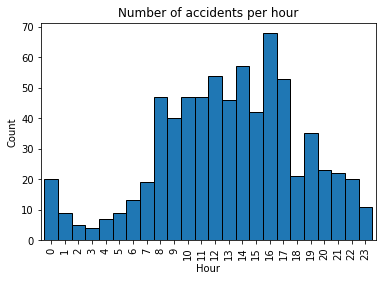

In [44]:
#For some reason to get this to work had to convert to an array and then create a dataframe
day_np = np.array(day)
day_df = pd.DataFrame(day_np)#, index=date_range)
_ = day_df.iloc[1,:].plot.bar(width=1, edgecolor='k')
plt.title('Number of accidents per hour')
plt.xlabel('Hour')
plt.ylabel('Count')

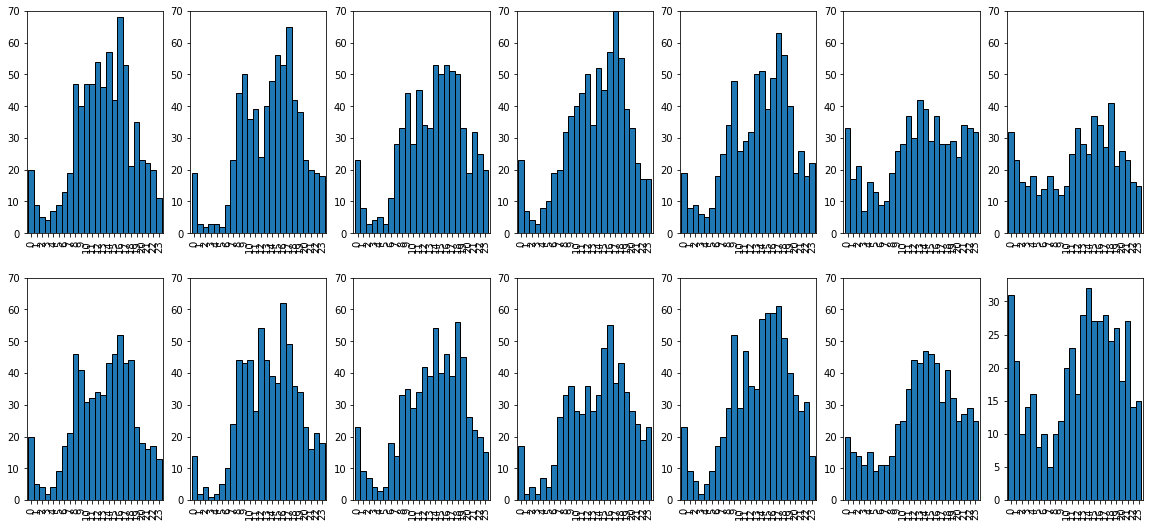

In [45]:
#Now lets look at 2 weeks of accident counts to qualitatively see if there are patterns.
for i in range(1,15,1):
    plt.rcParams["figure.figsize"] = (20, 9) # (w, h)
    plt.ylim((0,70))
    
    plt.subplot(2,7,i)
    _ = day_df.iloc[i,:].plot.bar(width=1, edgecolor='k')

The above plots go from Monday to Sunday, left to right for two consecutive weeks. Qualitatively, the patterns seem quite similar, with fairly consistent counts. Many appear to have a bimodal distribution, which judging by the times of day, may be associated with morning and evening rush hours. This may indicate that the accidents follow the traffic patterns - the more traffic that is on the road, the more accidents there are. This is unoubtably true, but it would be interesting to build a causal model, and determine whether there is a increased or decreased risk of accident throughout the day, irrespective of volume. For this, we'll need another dataset, one that gives the number of cars on the roads by hour.

Above shows the hourly pattern - let's take a look at the yealy pattern

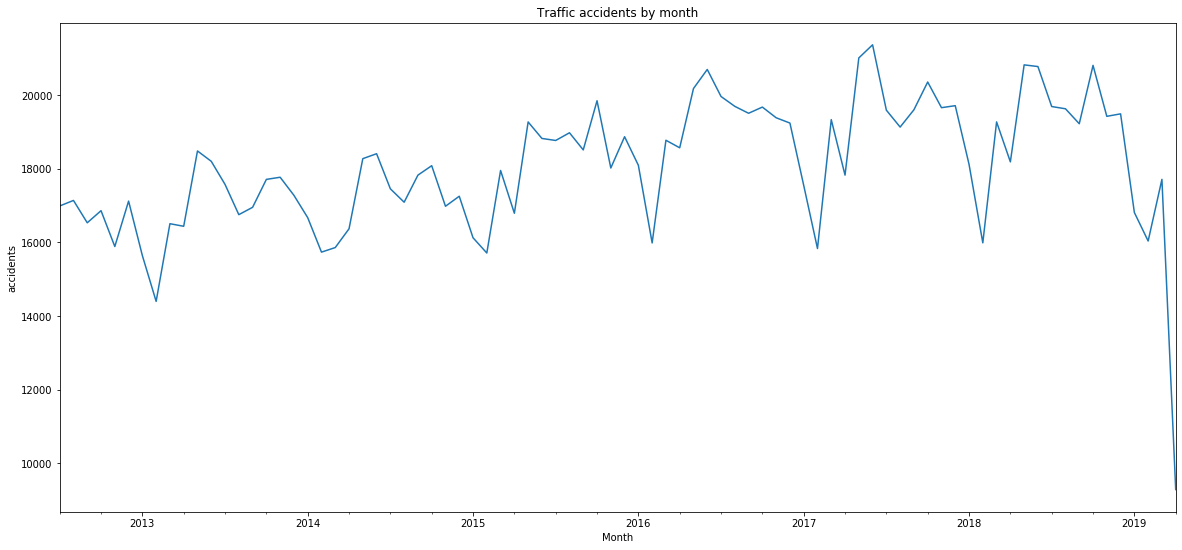

In [46]:
#Plot timecourse by month
monthly_count = traffic_df['date'].resample('MS').count()
_ = monthly_count.plot()
_ = plt.title('Traffic accidents by month')
_ = plt.xlabel('Month')
_ = plt.ylabel('accidents')
plt.savefig('accidents_by_month.png')

There seems to be some interesting seasonal variation in this data set, including a very low amount of accidents during April 2016. For this work, however,  we're going to focus on the hourly traffic accidents.

In [15]:
#Clean up further - deal with missing location data.
#Replace Nan with 0 then remove all lines with 0 in lat and long.
traffic_df.latitude = traffic_df.latitude.fillna(0)
#traffic_df = traffic_df.longitude.fillna(0)

In [16]:
traffic_df.head(5)

,date,time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,unique_key,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2019-04-16,2019-04-16,0:00,MANHATTAN,10010,40.737885,-73.98091,"(40.737885, -73.98091)",2 AVENUE,EAST 23 STREET,NaN,...,NaN,NaN,NaN,4116367,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11354,40.762756,-73.82261,"(40.762756, -73.82261)",PARSONS BOULEVARD,38 AVENUE,NaN,...,NaN,NaN,NaN,4115878,Sedan,Box Truck,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11367,40.729404,-73.82282,"(40.729404, -73.82282)",NaN,NaN,144-04 70 AVENUE,...,NaN,NaN,NaN,4115808,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11413,40.665485,-73.75374,"(40.665485, -73.75374)",SOUTH CONDUIT AVENUE,224 STREET,NaN,...,NaN,NaN,NaN,4115916,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,NaN,NaN,40.810173,-73.95117,"(40.810173, -73.95117)",WEST 125 STREET,NaN,NaN,...,NaN,NaN,NaN,4116309,Station Wagon/Sport Utility Vehicle,Taxi,NaN,NaN,NaN,2019-04-16


In [17]:
traffic_df.longitude = traffic_df.longitude.fillna(0)

In [18]:
traffic_df.head(5)

,date,time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,unique_key,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2019-04-16,2019-04-16,0:00,MANHATTAN,10010,40.737885,-73.98091,"(40.737885, -73.98091)",2 AVENUE,EAST 23 STREET,NaN,...,NaN,NaN,NaN,4116367,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11354,40.762756,-73.82261,"(40.762756, -73.82261)",PARSONS BOULEVARD,38 AVENUE,NaN,...,NaN,NaN,NaN,4115878,Sedan,Box Truck,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11367,40.729404,-73.82282,"(40.729404, -73.82282)",NaN,NaN,144-04 70 AVENUE,...,NaN,NaN,NaN,4115808,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11413,40.665485,-73.75374,"(40.665485, -73.75374)",SOUTH CONDUIT AVENUE,224 STREET,NaN,...,NaN,NaN,NaN,4115916,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,NaN,NaN,40.810173,-73.95117,"(40.810173, -73.95117)",WEST 125 STREET,NaN,NaN,...,NaN,NaN,NaN,4116309,Station Wagon/Sport Utility Vehicle,Taxi,NaN,NaN,NaN,2019-04-16


In [19]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1480084 entries, 2019-04-16 00:00:00 to 2012-07-01 09:59:00
Data columns (total 30 columns):
date                             1480084 non-null datetime64[ns]
time                             1480084 non-null object
borough                          1037441 non-null object
zip_code                         1037266 non-null object
latitude                         1480084 non-null float64
longitude                        1480084 non-null float64
location                         1294208 non-null object
on_street_name                   1196093 non-null object
cross_street_name                1007087 non-null object
off_street_name                  191840 non-null object
number_of_persons_injured        1480067 non-null float64
number_of_persons_killed         1480053 non-null float64
number_of_pedestrians_injured    1480084 non-null int64
number_of_pedestrians_killed     1480084 non-null int64
number_of_cyclist_injured        1480084 non-nu

In [20]:
traffic_df = traffic_df[(traffic_df[['latitude']] != 0).all(axis=1)]

In [21]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1293243 entries, 2019-04-16 00:00:00 to 2012-07-01 09:59:00
Data columns (total 30 columns):
date                             1293243 non-null datetime64[ns]
time                             1293243 non-null object
borough                          1010383 non-null object
zip_code                         1010225 non-null object
latitude                         1293243 non-null float64
longitude                        1293243 non-null float64
location                         1293243 non-null object
on_street_name                   1060703 non-null object
cross_street_name                887188 non-null object
off_street_name                  170677 non-null object
number_of_persons_injured        1293228 non-null float64
number_of_persons_killed         1293215 non-null float64
number_of_pedestrians_injured    1293243 non-null int64
number_of_pedestrians_killed     1293243 non-null int64
number_of_cyclist_injured        1293243 non-nul

From running .info() before, we saw that there were 1294208 non-null values for long and lat. Thus indicates there is almost 200k NaN values! Take a quick look:

[Back to Contents](#Contents)

Now that we've identified a problem with the locations of the accidents, let's take a look at the longitude and latitude data.

In [22]:
traffic_df.latitude.describe()

count    1.293243e+06
mean     4.072364e+01
std      7.911743e-02
min      3.078418e+01
25%      4.066871e+01
50%      4.072262e+01
75%      4.076775e+01
max      4.334444e+01
Name: latitude, dtype: float64

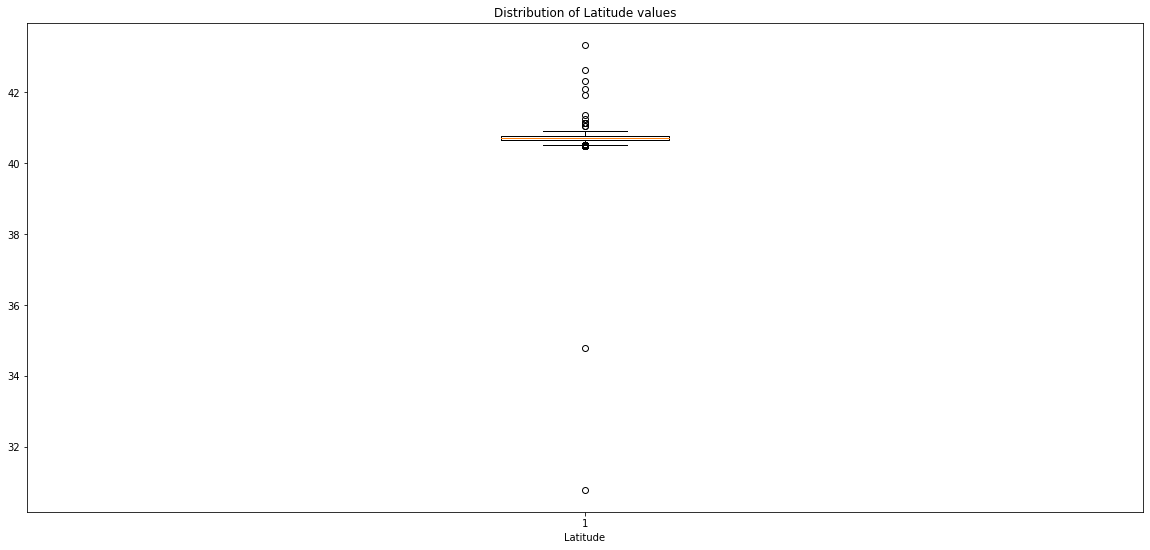

In [23]:
_ = plt.boxplot(traffic_df.latitude)
_ = plt.title('Distribution of Latitude values')
_ = plt.xlabel('Latitude')

In [24]:
clean_traffic_df = traffic_df[traffic_df.latitude > 36]
clean_traffic_df = clean_traffic_df[clean_traffic_df.latitude < 41.5]

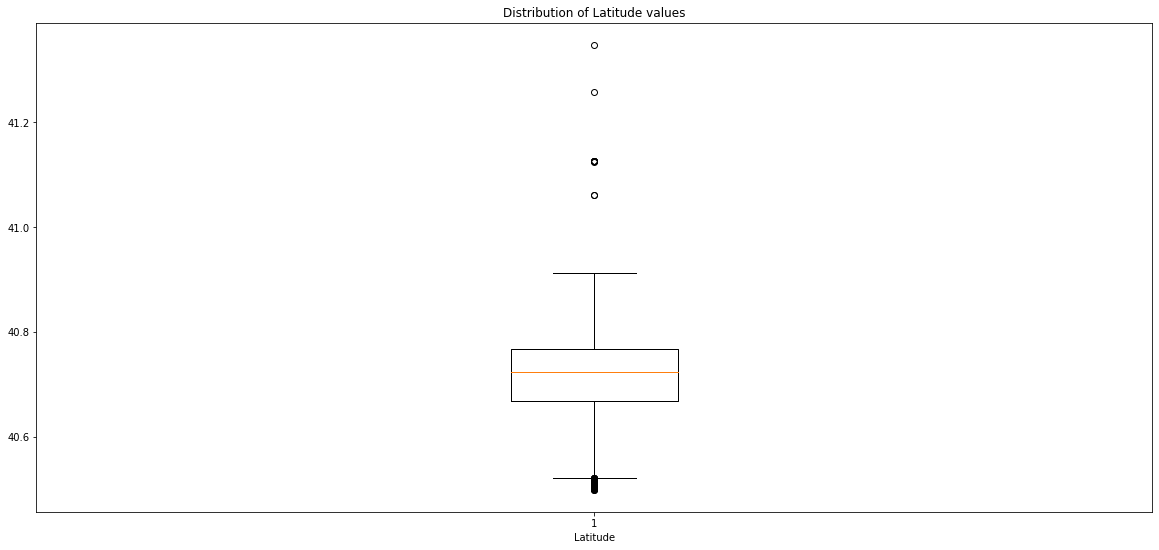

In [26]:
traffic_df.longitude.describe()

count    1.293243e+06
mean    -7.393220e+01
std      1.165776e+00
min     -2.013600e+02
25%     -7.397798e+01
50%     -7.393075e+01
75%     -7.386771e+01
max     -3.276851e+01
Name: longitude, dtype: float64

In [27]:
clean_traffic_df = traffic_df[traffic_df.longitude > -74.4]
clean_traffic_df = clean_traffic_df[clean_traffic_df.longitude < -60]

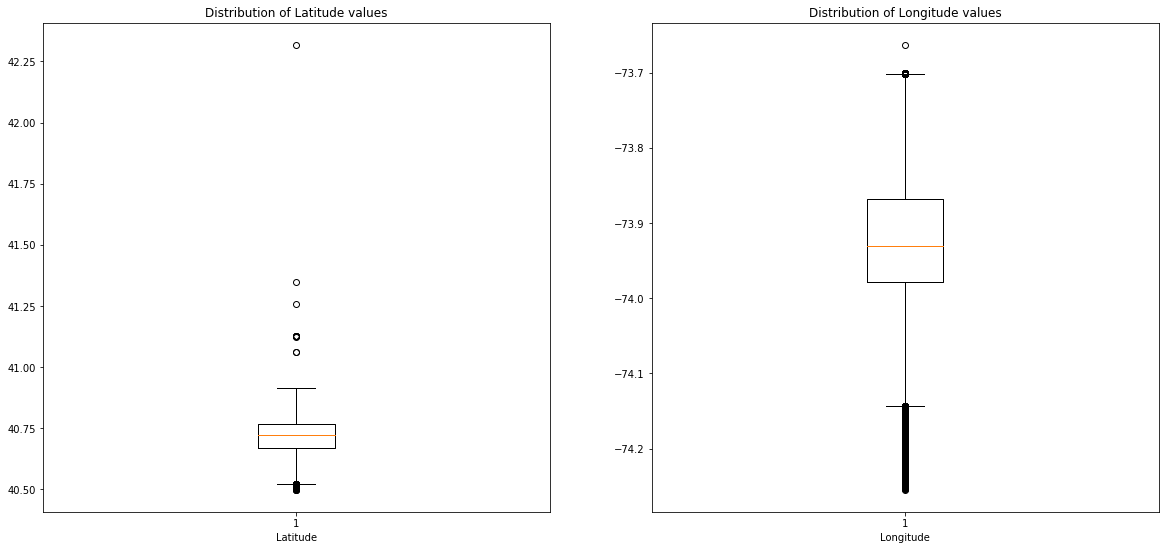

In [49]:
plt.subplot(1,2,1)
_ = plt.boxplot(clean_traffic_df.latitude)
_ = plt.title('Distribution of Latitude values')
_ = plt.xlabel('Latitude')
plt.subplot(1,2,2)
_ = plt.boxplot(clean_traffic_df.longitude)
plt.title('Distribution of Longitude values')
plt.xlabel('Longitude')
plt.savefig('lat_long_accident.png')

There is quite a bit of variation in the values of longitude and latitude. We've got rid of the most extreme values, but for  our analysis, we'll make the assumption that the presence of an entry in this database was generated by NYPD, and therefore in the NY City area, and do no further removal of datapoints. As you can see below, we're left with 1.29 million entries.

In [29]:
clean_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1293105 entries, 2019-04-16 00:00:00 to 2012-07-01 09:59:00
Data columns (total 30 columns):
date                             1293105 non-null datetime64[ns]
time                             1293105 non-null object
borough                          1010383 non-null object
zip_code                         1010225 non-null object
latitude                         1293105 non-null float64
longitude                        1293105 non-null float64
location                         1293105 non-null object
on_street_name                   1060568 non-null object
cross_street_name                887188 non-null object
off_street_name                  170677 non-null object
number_of_persons_injured        1293090 non-null float64
number_of_persons_killed         1293077 non-null float64
number_of_pedestrians_injured    1293105 non-null int64
number_of_pedestrians_killed     1293105 non-null int64
number_of_cyclist_injured        1293105 non-nul

In [30]:
#Save df to csv 
clean_traffic_df.to_csv(path_or_buf='accident_df.csv')

End of notebook